## Outline

1. Recap of what we did last time
2. Why do we use batching
3. Batching for sequence models
4. Padding and packing in PyTorch
5. Training with batched dataset
6. Comparison of performance with batching and on GPU

### Setting up the dependencies

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from IPython.display import clear_output

## Dataset

### Pre-processing

In [7]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [8]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [9]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Test-train split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [11]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [12]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [13]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [14]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [15]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [16]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [17]:
lang_rep('Portuguese')

tensor([0])

### Basic visualisation

In [18]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [19]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


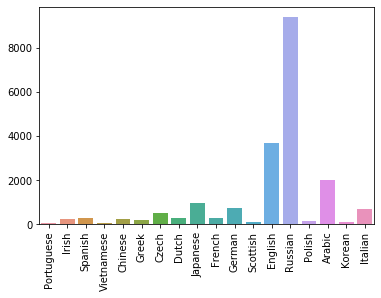

In [20]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic network and testing inference

In [21]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [22]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [23]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [24]:
infer(net, 'Adam')

tensor([[-2.9731, -2.7245, -2.9527, -2.7712, -2.8390, -2.9203, -2.8711, -2.8111,
         -2.9136, -2.9349, -2.8926, -2.9345, -2.9648, -2.8131, -2.9653, -2.8056,
         -3.0620, -2.9389]], grad_fn=<LogSoftmaxBackward>)

## Evaluate model

In [25]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [26]:
dataloader(2, X_train, y_train)

[('Wong',
  'English',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [27]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [28]:
eval(net, 1000, 1, X_test, y_test)

0.008

# Batching

It brings performance improvement through vectorization
    
    -->If we have some task to perform we can do them individually 
    -->or we can perform larger vectors of different data items & do work parallely

There are 2 aspect of batching-->


![!title](./Batching1.PNG)

<b>VECTORIZATION</b>
    
    Doing parallely has been exploited heavily by using GPU
    VECTORIZATION brings improvement in performance because of Single Instruction Multiple Data kind of parallelism we have

<b>AGGREGATED GRADIENT COMPUTATION</b>
    
    --> We can take lets say one image do gradient computation in CNN & then update the parameter then another image and update parameters, when we do this what we found that these gradient update are bit noisy, so it increases the variance because of different updates
    -->To reduce this variance we do batching
    -->We compute multiple gradient for multiple data items --> Aggregate it --> then do one update
    -->So we do one update per batch
    -->This lead to much more stable training procedure

So now we will do batching to achieve VECTORIZATION mainly








<b>UNDERSTAND VECTORIZATION</b>
Suppose we want our model to look into 2 words simultaneously
For each word we have different number of characters 
Each character --> represented in fix one hot encoding format

We can do padding

![!title](./Batching2.PNG)

If we simply do padding it will not fulfill our purpose

We can improve by following 3 steps

![!title](./Batching11.PNG)

Batchsize have been stored additionally here





In [30]:
# Previously we use one name and create tensor of it
# But here we are considering multiple names in list names as input and will do padding according to max_word_size defined

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    # First index is slowest moving index
    # Second index is batch size
    # Third index is size of vocab or letters here
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
            # For PAD all 57 values are zeros
    return rep

In [31]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

<b>Below is example and its padding example</b>

![title](./RamShyam.PNG)


In [32]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

#Why output is like this
#S first letter of first word
#R first letter of second word

#h 2nd letter of first word
#a 2nd letter of second word

#y 3rd letter of first word
#m 3rd letter of second word

#a 4th letter of first word
#<pad> 4th letter of second word

#m 5th letter of first word
#<pad> 5th letter of second word


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [33]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [38]:
# We are writing a data loaderr for packing
# verbose used for troubleshooting
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        # First we sample X randomly & then have corresponding name and lang
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    # The names list which we created above randomly we padded them and then try to vectorize them
    # similarly for lang
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    # Now after that we do PACKING using this single command
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        # Here we are printing original shape and pack_padded both
        print('--')
    
    if verbose:
        print(names)
        # Printing names and there characters after passing through print_char
        print_char(names_rep)
        print('--')
    
    if verbose:
        print('--'*5)
        print('After Packing')
        print('--'*5)
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('--'*5)
        print('After Packing batch size')
        # Batch_size here is the same what we discussed is used during packing
        # This Batch size is different it is what we discussed during paking
        print('--'*5)
        print('Batch sizes', padded_names_rep.batch_sizes)
        print('--')
    
    return padded_names_rep.to(device), langs_rep

In [39]:
# Here first index 3 means we want 3 data to be taken from X_train

p, l = batched_dataloader(3, X_train, y_train, True)
#torch.Size([9, 3, 57]) torch.Size([21, 57])
# second size is of packed one so we save size here


torch.Size([9, 3, 57]) torch.Size([23, 57])
--
['Baumhauer', 'Baikalov', 'Isakov']
B
B
I
a
a
s
u
i
a
m
k
k
h
a
o
a
l
v
u
o
<pad>
e
v
<pad>
r
<pad>
<pad>
--
----------
After Packing
----------
B
B
I
a
a
s
u
i
a
m
k
k
h
a
o
a
l
v
u
o
e
v
r
Lang Rep tensor([10, 13, 13])
----------
After Packing batch size
----------
Batch sizes tensor([3, 3, 3, 3, 3, 3, 2, 2, 1])
--


## Training

### Basic setup

In [40]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [41]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    # We are using batched_loader and get the data
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    # Once we get the data we will pass it through net
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [42]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [43]:
%%time 
train(net, opt, criterion, 256)

Wall time: 955 ms


tensor(2.9499, grad_fn=<DivBackward0>)

In [44]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [45]:
%%time 
train_batch(net, opt, criterion, 256)
# It take much smaller time

Wall time: 60.3 ms


tensor(2.8872, grad_fn=<NllLossBackward>)

### Full training setup

In [46]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

## RNN Cell

Iteration 4999 Loss 0.46889039874076843


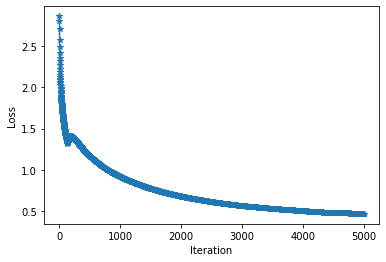




Top-1: 0.7506234413965087 Top-2: 0.8675810473815462
Wall time: 17min 1s


In [47]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

Iteration 4999 Loss 0.5059587359428406


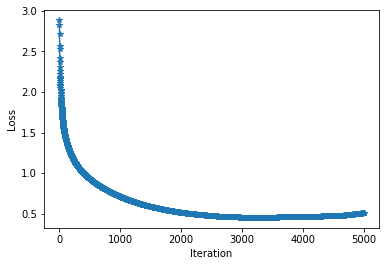




Top-1: 0.6827930174563591 Top-2: 0.8072319201995013
Wall time: 7min 27s


In [48]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

## LSTM cell

In [49]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.24878621101379395


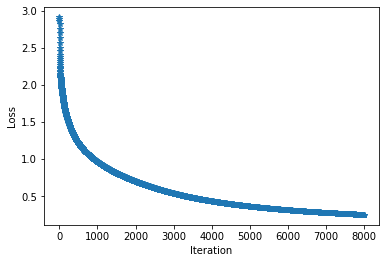




Top-1: 0.8014962593516209 Top-2: 0.887281795511222


In [50]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)

## GRU Cell

In [51]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 7999 Loss 0.21987512707710266


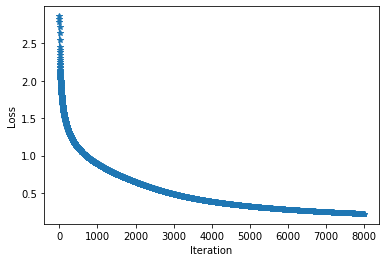




Top-1: 0.7997506234413965 Top-2: 0.8877805486284289


In [52]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)